<a href="https://colab.research.google.com/github/Ayan1311819/Micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# micrograd
class Value:
  def __init__(self,data,_children={},_op='',label=''):
    self.data=data
    self._op=_op
    self.grad = 0.0
    self._backward = lambda:None
    self._prev = set(_children)
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')   #a + b = a._add_(b)
    def _backward():
      self.grad += 1*out.grad
      other.grad += 1*out.grad #It overwrites if we encounter the same variable but they should get accumulate so +=
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data,(self,other),'*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out
  def __rmul__(self,other): #2*a = 2.__mul__(a)
    return self*other       #a*2
  def tanh(self):
    n=self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1-t**2)*out.grad
    out._backward=_backward  #we don't want to call the func but to store them
    return out
  def backward(self):
    topo=[]
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph
#Code for visualization
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

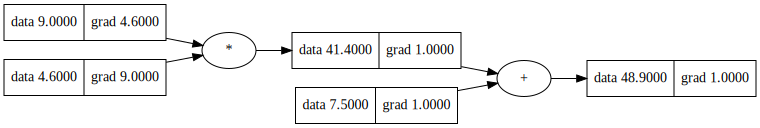

In [ ]:
a = Value(7.5)
b = Value(4.6)
c = Value(9)
m = b*c
d=a+m
a.label='a'
b.label='b'
c.label='c'
d.label='d'
m.label ='m'
d.grad=1
d._backward()
m._backward()
#d.backward()
draw_dot(d)

In [ ]:
#d.grad=1
#d._backward()
#m._backward() #If run multiple times it will accumuate the gradient multiple times
#d.backward()
#draw_dot(d)
# We can update all the nodes in the direction of gradient

In [ ]:
#Derivative and chain rule
#L will go up in the direction of gradient
#We don't necessarily need to have the most atomic pieces in this value object we can create functions at arbitrary points of abstraction .
#If you know how input affects the output that's all you need
#Initialize L.grad with 1


import torch
import random
import math
#NEURAL NET

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w+[self.b]

class Layer:
    def __init__(self,nin,nout):
      self.neurons = [Neuron(nin)for _ in range(nout)]
    def __call__(self,x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs)==1 else outs
    def parameters(self):
      params=[]
      for neuron in self.neurons:
        ps=neuron.parameters
        params.extend(ps)
      return params

class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range (len(nouts))]
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [ p for layer in self.layers for p in layer.parameters()]


In [ ]:
x=[2.0,4.0]
n = MLP(2,[3,5,1])
n(x)
#draw_dot(n(x))

Value(data=-0.8059151578202923)

In [ ]:
R = (n(x))
R.backward()
#draw_dot(R)